In [48]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ----------------------------------------
# Step 1: Load and Clean Data
# ----------------------------------------
df = pd.read_csv("/Users/Intel/Desktop/spring 2025/CAPSTONE/cleaned_data.csv", low_memory=False)
df['FIRST_OCCURRENCE_DATE'] = pd.to_datetime(df['FIRST_OCCURRENCE_DATE'], errors='coerce')
df = df.dropna(subset=['FIRST_OCCURRENCE_DATE'])

# ----------------------------------------
# Step 2: Aggregate Daily Crime Count
# ----------------------------------------
daily_crime = df.groupby(df['FIRST_OCCURRENCE_DATE'].dt.date).size().reset_index(name='Crime_Count')
daily_crime.columns = ['Date', 'Crime_Count']
daily_crime['Date'] = pd.to_datetime(daily_crime['Date'])

# ----------------------------------------
# Step 3: Feature Engineering
# ----------------------------------------
daily_crime['day_of_week'] = daily_crime['Date'].dt.dayofweek
daily_crime['month'] = daily_crime['Date'].dt.month
daily_crime['year'] = daily_crime['Date'].dt.year
daily_crime['day_of_year'] = daily_crime['Date'].dt.dayofyear

# Lag and Rolling Features
daily_crime['lag_1'] = daily_crime['Crime_Count'].shift(1)
daily_crime['lag_7'] = daily_crime['Crime_Count'].shift(7)
daily_crime['rolling_7'] = daily_crime['Crime_Count'].rolling(window=7).mean()
daily_crime['rolling_30'] = daily_crime['Crime_Count'].rolling(window=30).mean()

# Drop NaNs from lag/rolling
daily_crime = daily_crime.dropna()
daily_crime = daily_crime.reset_index(drop=True)  # ✅ Important for index alignment

# ----------------------------------------
# Step 4: Save Preprocessed Data
# ----------------------------------------
daily_crime.to_csv("/Users/Intel/Desktop/spring 2025/CAPSTONE/final_daily_crime_trend.csv", index=False)

# ----------------------------------------
# Step 5: Train LightGBM Model
# ----------------------------------------
features = ['day_of_week', 'month', 'day_of_year', 'lag_1', 'lag_7', 'rolling_7', 'rolling_30']
X = daily_crime[features]
y = daily_crime['Crime_Count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[test_data],
    num_boost_round=500,
    callbacks=[lgb.early_stopping(50)]
)

# ----------------------------------------
# Step 6: Evaluate & Save Predictions
# ----------------------------------------
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n📊 FINAL LIGHTGBM MODEL PERFORMANCE")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Align Dates (now this will work perfectly)
results_df = X_test.copy()
results_df.insert(0, 'Date', daily_crime.loc[X_test.index, 'Date'].values)  # ✅ safer insert
results_df['Actual_Crime_Count'] = y_test.values
results_df['Predicted_Crime_Count'] = y_pred
results_df = results_df[['Date'] + features + ['Actual_Crime_Count', 'Predicted_Crime_Count']]

results_df.to_csv("/Users/Intel/Desktop/spring 2025/CAPSTONE/crime_rate_predictions.csv", index=False)
print("\n✅ Saved predictions to 'crime_rate_predictions.csv'")


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's rmse: 20.0583

📊 FINAL LIGHTGBM MODEL PERFORMANCE
RMSE: 20.0583
MAE: 15.5461
R² Score: 0.3312

✅ Saved predictions to 'crime_rate_predictions.csv'


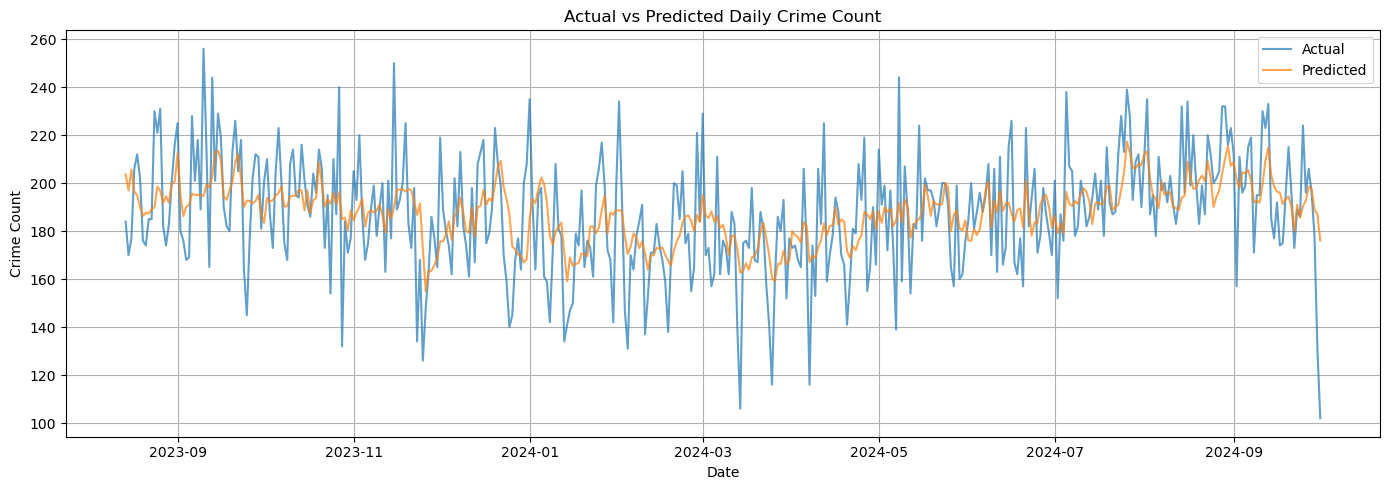

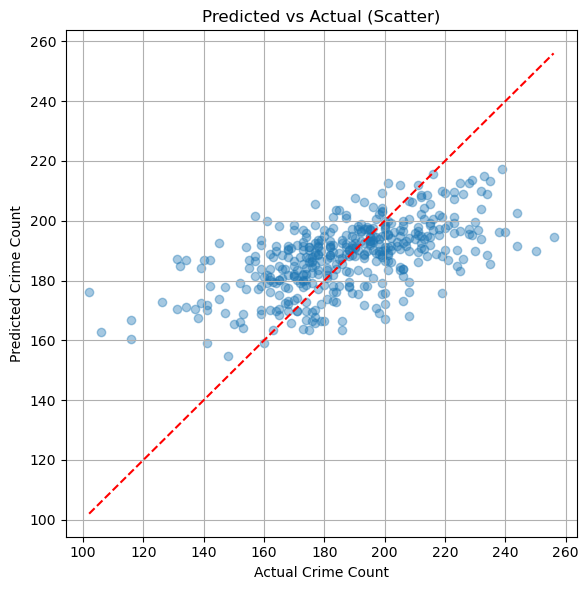

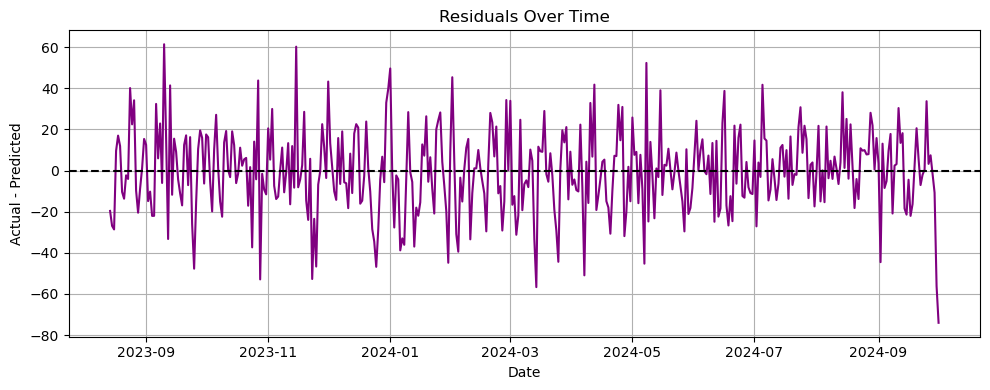

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Load predictions
results_df = pd.read_csv("/Users/Intel/Desktop/crime_rate_predictions.csv", parse_dates=["Date"])

# 1. 📈 Actual vs Predicted (Line Plot)
plt.figure(figsize=(14, 5))
plt.plot(results_df['Date'], results_df['Actual_Crime_Count'], label='Actual', alpha=0.7)
plt.plot(results_df['Date'], results_df['Predicted_Crime_Count'], label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Daily Crime Count')
plt.xlabel('Date')
plt.ylabel('Crime Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. 🔍 Scatter Plot (Predicted vs Actual)
plt.figure(figsize=(6, 6))
plt.scatter(results_df['Actual_Crime_Count'], results_df['Predicted_Crime_Count'], alpha=0.4)
plt.plot([results_df['Actual_Crime_Count'].min(), results_df['Actual_Crime_Count'].max()],
         [results_df['Actual_Crime_Count'].min(), results_df['Actual_Crime_Count'].max()],
         color='red', linestyle='--')
plt.xlabel("Actual Crime Count")
plt.ylabel("Predicted Crime Count")
plt.title("Predicted vs Actual (Scatter)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. 📊 Residual Plot
residuals = results_df['Actual_Crime_Count'] - results_df['Predicted_Crime_Count']
plt.figure(figsize=(10, 4))
plt.plot(results_df['Date'], residuals, label='Residuals', color='purple')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Actual - Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()


In [83]:
# ----------------------------------------
# Required Libraries
# ----------------------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam

# ----------------------------------------
# Load and Prepare Data
# ----------------------------------------
data = pd.read_csv("/Users/Intel/Desktop/spring 2025/CAPSTONE/cleaned_data.csv")
data['FIRST_OCCURRENCE_DATE'] = pd.to_datetime(data['FIRST_OCCURRENCE_DATE'])
data = data.dropna(subset=['FIRST_OCCURRENCE_DATE'])

# ----------------------------------------
# Aggregate Crime Data (Daily)
# ----------------------------------------
daily_crime = data.groupby(data['FIRST_OCCURRENCE_DATE'].dt.date).size().reset_index(name='Crime_Count')
daily_crime.columns = ['Date', 'Crime_Count']
daily_crime['Date'] = pd.to_datetime(daily_crime['Date'])

# ----------------------------------------
# Define Crime Binning for Classification
# ----------------------------------------
def bin_crime(count):
    if count < 150:
        return 0  # Low Crime
    elif count < 200:
        return 1  # Medium Crime
    else:
        return 2  # High Crime

daily_crime['Crime_Class'] = daily_crime['Crime_Count'].apply(bin_crime)

# ----------------------------------------
# Feature Engineering
# ----------------------------------------
daily_crime['day_of_week'] = daily_crime['Date'].dt.dayofweek
daily_crime['month'] = daily_crime['Date'].dt.month
daily_crime['day_of_year'] = daily_crime['Date'].dt.dayofyear
daily_crime['is_weekend'] = daily_crime['day_of_week'].isin([5, 6]).astype(int)
daily_crime['lag_1'] = daily_crime['Crime_Count'].shift(1)
daily_crime['lag_7'] = daily_crime['Crime_Count'].shift(7)
daily_crime['lag_14'] = daily_crime['Crime_Count'].shift(14)
daily_crime['rolling_7'] = daily_crime['Crime_Count'].rolling(7).mean()
daily_crime['rolling_14'] = daily_crime['Crime_Count'].rolling(14).mean()
daily_crime['rolling_30'] = daily_crime['Crime_Count'].rolling(30).mean()

daily_crime = daily_crime.dropna().reset_index(drop=True)

# ----------------------------------------
# Define Features and Targets
# ----------------------------------------
features = ['day_of_week', 'month', 'day_of_year', 'is_weekend',
            'lag_1', 'lag_7', 'lag_14', 'rolling_7', 'rolling_14', 'rolling_30']

X = daily_crime[features]
y_class = daily_crime['Crime_Class']
y_reg = daily_crime['Crime_Count']

# Split Data
X_train, X_test, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, shuffle=False)
_, _, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, shuffle=False)

# Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Encode Labels for Classification
le = LabelEncoder()
y_train_class_encoded = le.fit_transform(y_train_class)
y_test_class_encoded = le.transform(y_test_class)

# ----------------------------------------
# Build Neural Network Model
# ----------------------------------------
input_layer = Input(shape=(X_train_scaled.shape[1],))

# Shared Hidden Layers
x = Dense(128, activation='relu')(input_layer)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)

# Regression Branch
regression_output = Dense(1, activation='linear', name='regression_output')(x)

# Classification Branch
classification_output = Dense(3, activation='softmax', name='classification_output')(x)

# Combine Model
model = Model(inputs=input_layer, outputs=[regression_output, classification_output])

# Compile the Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={'regression_output': 'mse', 'classification_output': 'sparse_categorical_crossentropy'},
    metrics={'regression_output': ['mse', 'mae'], 'classification_output': 'accuracy'}
)

# ----------------------------------------
# Train the Model
# ----------------------------------------
history = model.fit(
    X_train_scaled,
    {'regression_output': y_train_reg, 'classification_output': y_train_class_encoded},
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    verbose=1
)

# ----------------------------------------
# Model Evaluation
# ----------------------------------------
y_pred_reg, y_pred_class_prob = model.predict(X_test_scaled)

# Regression Results
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
r2 = r2_score(y_test_reg, y_pred_reg)
print(f"\n📊 NN REGRESSION RESULTS:\n✅ RMSE: {rmse:.4f}\n✅ R² Score: {r2:.4f}")

# Classification Results
y_pred_class = np.argmax(y_pred_class_prob, axis=1)
accuracy = accuracy_score(y_test_class_encoded, y_pred_class)
print(f"\n📊 NN CLASSIFICATION RESULTS:\n✅ Accuracy: {accuracy * 100:.2f}%")
print("\n🔍 Classification Report:\n", classification_report(y_test_class_encoded, y_pred_class))

# ----------------------------------------
# Save Predictions
# ----------------------------------------
output = X_test.copy()
output.insert(0, 'Date', daily_crime.loc[X_test.index, 'Date'].values)
output['Actual_Crime_Count'] = y_test_reg.values
output['Predicted_Crime_Count'] = y_pred_reg.flatten()
output['Actual_Class'] = y_test_class.values
output['Predicted_Class'] = le.inverse_transform(y_pred_class)

output.to_csv("/Users/Intel/Desktop/spring 2025/CAPSTONE/final_nn_crime_model.csv", index=False)
print("\n✅ Saved to 'final_nn_crime_model.csv'")


Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - classification_output_accuracy: 0.3821 - classification_output_loss: 1.0973 - loss: 46799.4375 - regression_output_loss: 46784.7852 - regression_output_mae: 186.2165 - regression_output_mse: 46798.3359 - val_classification_output_accuracy: 0.4217 - val_classification_output_loss: 1.0576 - val_loss: 39400.8320 - val_regression_output_loss: 40036.7227 - val_regression_output_mae: 197.0213 - val_regression_output_mse: 39399.7617
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - classification_output_accuracy: 0.4276 - classification_output_loss: 1.0864 - loss: 40035.9492 - regression_output_loss: 40022.8359 - regression_output_mae: 179.1413 - regression_output_mse: 40034.8594 - val_classification_output_accuracy: 0.5392 - val_classification_output_loss: 0.8889 - val_loss: 38162.7227 - val_regression_output_loss: 38799.7930 - val_regression_output_mae: 193.8484 - val_regression_output_mse: 38161.8281
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━

/Users/Intel/Desktop/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Intel/Desktop/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Intel/Desktop/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [89]:
# ----------------------------------------
# Import Required Libraries
# ----------------------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

# ----------------------------------------
# Load and Prepare Data
# ----------------------------------------
# Load preprocessed data
df = pd.read_csv("/Users/Intel/Desktop/spring 2025/CAPSTONE/cleaned_data.csv")

# Convert Date column to datetime if not already done
df['FIRST_OCCURRENCE_DATE'] = pd.to_datetime(df['FIRST_OCCURRENCE_DATE'], errors='coerce')
df = df.dropna(subset=['FIRST_OCCURRENCE_DATE'])

# Aggregate crime counts per day
daily_crime = df.groupby(df['FIRST_OCCURRENCE_DATE'].dt.date).size().reset_index(name='Crime_Count')
daily_crime.columns = ['Date', 'Crime_Count']
daily_crime['Date'] = pd.to_datetime(daily_crime['Date'])

# ----------------------------------------
# Custom Crime Binning (Fixed Ranges)
# ----------------------------------------
def bin_crime(count):
    if count < 150:
        return 0  # Low Crime
    elif count < 200:
        return 1  # Medium Crime
    else:
        return 2  # High Crime

daily_crime['Crime_Class'] = daily_crime['Crime_Count'].apply(bin_crime)

# ----------------------------------------
# Feature Engineering
# ----------------------------------------
daily_crime['day_of_week'] = daily_crime['Date'].dt.dayofweek
daily_crime['month'] = daily_crime['Date'].dt.month
daily_crime['day_of_year'] = daily_crime['Date'].dt.dayofyear
daily_crime['is_weekend'] = daily_crime['day_of_week'].isin([5, 6]).astype(int)

# Add lag and rolling features
daily_crime['lag_1'] = daily_crime['Crime_Count'].shift(1)
daily_crime['lag_7'] = daily_crime['Crime_Count'].shift(7)
daily_crime['rolling_7'] = daily_crime['Crime_Count'].rolling(7).mean()
daily_crime['rolling_30'] = daily_crime['Crime_Count'].rolling(30).mean()

# Drop NaN rows created due to lagging/rolling
daily_crime = daily_crime.dropna().reset_index(drop=True)

# ----------------------------------------
# Prepare Train/Test Data
# ----------------------------------------
features = ['day_of_week', 'month', 'day_of_year', 'is_weekend', 'lag_1', 'lag_7', 'rolling_7', 'rolling_30']
X = daily_crime[features]
y_class = daily_crime['Crime_Class']
y_reg = np.log1p(daily_crime['Crime_Count'])  # Log-transform for regression stability

# Train-test split
X_train, X_test, y_class_train, y_class_test, y_reg_train, y_reg_test = train_test_split(
    X, y_class, y_reg, test_size=0.2, random_state=42, shuffle=False
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ----------------------------------------
# Define Neural Network Architecture
# ----------------------------------------
input_layer = Input(shape=(X_train_scaled.shape[1],))
hidden1 = Dense(64, activation='relu')(input_layer)
hidden2 = Dense(32, activation='relu')(hidden1)

# Separate outputs for classification and regression
classification_output = Dense(3, activation='softmax', name='classification_output')(hidden2)
regression_output = Dense(1, name='regression_output')(hidden2)

# Create model with multiple outputs
model = Model(inputs=input_layer, outputs=[classification_output, regression_output])
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={
        'classification_output': 'sparse_categorical_crossentropy',
        'regression_output': 'mse'
    },
    metrics={
        'classification_output': 'accuracy',
        'regression_output': ['mae', 'mse']
    }
)

# ----------------------------------------
# Train Neural Network
# ----------------------------------------
history = model.fit(
    X_train_scaled,
    {'classification_output': y_class_train, 'regression_output': y_reg_train},
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    verbose=1
)

# ----------------------------------------
# Evaluate Neural Network
# ----------------------------------------
eval_results = model.evaluate(
    X_test_scaled,
    {'classification_output': y_class_test, 'regression_output': y_reg_test},
    verbose=0
)

print(f"\n📊 EVALUATION RESULTS:")
print(f"✅ Classification Accuracy: {round(eval_results[3] * 100, 2)}%")

# 🔎 Check Available Metric Names
print(f"📚 Available Metrics: {model.metrics_names}")

# Dynamically Get RMSE and R²
try:
    # Find the RMSE based on regression MSE
    mse_index = next(i for i, metric in enumerate(model.metrics_names) if "regression_output_mse" in metric)
    rmse = np.sqrt(eval_results[mse_index])
    r2_score = 1 - (eval_results[mse_index] / np.var(y_reg_test))
    print(f"✅ RMSE: {round(rmse, 4)}")
    print(f"✅ R² Score: {round(r2_score, 4)}")
except StopIteration:
    print("⚠️ MSE metric not found! Check 'model.metrics_names' for available options.")


# ----------------------------------------
# XGBoost for Ensembling
# ----------------------------------------
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    objective='multi:softmax',
    num_class=3,
    random_state=42
)

xgb_model.fit(X_train, y_class_train)
xgb_preds = xgb_model.predict(X_test)

xgb_acc = accuracy_score(y_class_test, xgb_preds)
print(f"\n🚀 XGBoost Classification Accuracy: {round(xgb_acc * 100, 2)}%")

# ----------------------------------------
# Save Predictions to CSV
# ----------------------------------------
final_output = pd.DataFrame({
    'Date': daily_crime.loc[X_test.index, 'Date'].values,
    'Actual_Class': y_class_test,
    'Predicted_Class': np.argmax(model.predict(X_test_scaled)[0], axis=1),
    'Actual_Count': np.expm1(y_reg_test),  # Inverse of log
    'Predicted_Count': np.expm1(model.predict(X_test_scaled)[1].flatten()),  # Inverse of log
    'XGB_Pred_Class': xgb_preds
})

final_output.to_csv("/Users/Intel/Desktop/spring 2025/CAPSTONE/final_nn_xgb_model_v3.csv", index=False)
print("\n✅ Saved to 'final_nn_xgb_model_v3.csv'")


Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - classification_output_accuracy: 0.5214 - classification_output_loss: 1.0824 - loss: 22.8321 - regression_output_loss: 21.7422 - regression_output_mae: 4.6160 - regression_output_mse: 21.7498 - val_classification_output_accuracy: 0.5241 - val_classification_output_loss: 0.9052 - val_loss: 10.5606 - val_regression_output_loss: 9.6377 - val_regression_output_mae: 3.0521 - val_regression_output_mse: 9.6611
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - classification_output_accuracy: 0.5421 - classification_output_loss: 1.0787 - loss: 8.3748 - regression_output_loss: 7.2932 - regression_output_mae: 2.3952 - regression_output_mse: 7.2960 - val_classification_output_accuracy: 0.5211 - val_classification_output_loss: 0.8854 - val_loss: 3.4976 - val_regression_output_loss: 2.6155 - val_regression_output_mae: 1.4258 - val_regression_output_mse: 2.6145
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - classification_output_accuracy: 0.56

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=19344.109, Time=14.16 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=20456.313, Time=0.21 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=20001.167, Time=1.12 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=19344.642, Time=4.15 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=20454.314, Time=0.07 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=19348.267, Time=9.33 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=19348.249, Time=7.61 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=19333.962, Time=17.41 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=19332.993, Time=11.31 sec
 ARIMA(1,1,2)(2,0,0)[7] intercept   : AIC=19331.851, Time=10.51 sec
 ARIMA(1,1,2)(1,0,0)[7] intercept   : AIC=19346.955, Time=6.51 sec
 ARIMA(1,1,2)(2,0,1)[7] intercept   : AIC=19332.729, Time=10.04 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=19342.410, Time=9.30 sec
 ARIMA(0,1,2)(2,0,0)[7] intercept   : AIC=19329.967, Time=7.23 sec
 ARIMA(0,1,2)(

/Users/Intel/Desktop/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Intel/Desktop/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                        Crime_Count   No. Observations:                 1680
Model:             SARIMAX(0, 1, 1)x(2, 0, [], 7)   Log Likelihood               -9585.667
Date:                            Fri, 28 Mar 2025   AIC                          19179.334
Time:                                    23:49:14   BIC                          19201.005
Sample:                                01-02-2019   HQIC                         19187.365
                                     - 08-08-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9791      0.008   -116.727      0.000      -0.996      -0.963
ar.S.L7       -0.0163      0.057   

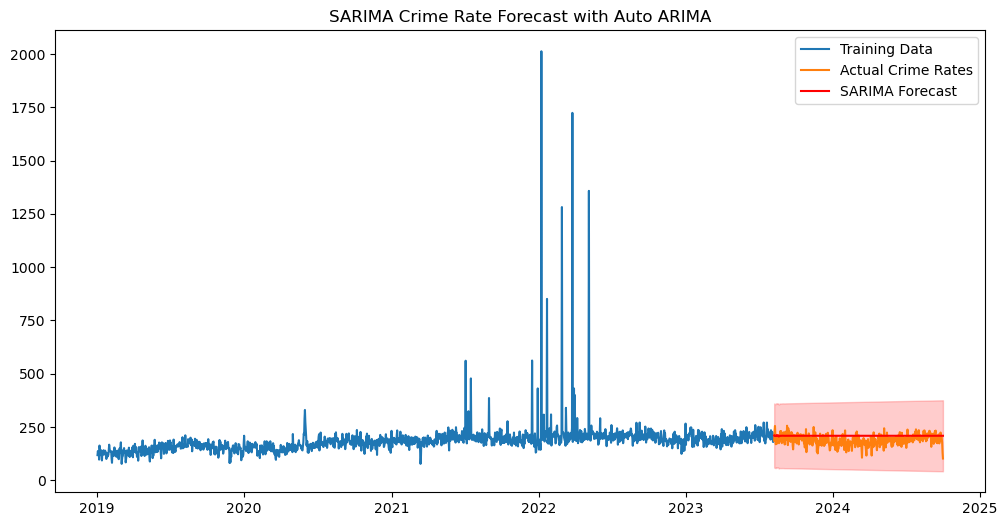

✅ RMSE: 32.54
✅ R² Score: -0.7268
✅ Forecast saved to 'final_sarima_crime_forecast.csv'


In [5]:
from pmdarima import auto_arima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# ----------------------------------------
# Load and Prepare Data
# ----------------------------------------
file_path = '/Users/Intel/Desktop/spring 2025/CAPSTONE/cleaned_data.csv'  # Update this path
data = pd.read_csv(file_path)

# Convert date to datetime and set as index
data['FIRST_OCCURRENCE_DATE'] = pd.to_datetime(data['FIRST_OCCURRENCE_DATE'])
data_daily = data.groupby(data['FIRST_OCCURRENCE_DATE'].dt.date).size().reset_index(name='Crime_Count')
data_daily['FIRST_OCCURRENCE_DATE'] = pd.to_datetime(data_daily['FIRST_OCCURRENCE_DATE'])
data_daily.set_index('FIRST_OCCURRENCE_DATE', inplace=True)

# ----------------------------------------
# Train-Test Split
# ----------------------------------------
train_size = int(len(data_daily) * 0.8)
train, test = data_daily.iloc[:train_size], data_daily.iloc[train_size:]

# ----------------------------------------
# Auto ARIMA for Optimal Parameters
# ----------------------------------------
# Auto-detect best (p, d, q) and seasonal (P, D, Q, s) parameters
auto_model = auto_arima(train['Crime_Count'], 
                        seasonal=True, 
                        m=7,  # Weekly seasonality
                        trace=True, 
                        error_action='ignore', 
                        suppress_warnings=True,
                        stepwise=True)

print(f"✅ Best SARIMA Order: {auto_model.order}")
print(f"✅ Best Seasonal Order: {auto_model.seasonal_order}")

# ----------------------------------------
# Fit SARIMA with Optimal Parameters
# ----------------------------------------
sarima_model = SARIMAX(train['Crime_Count'],
                       order=auto_model.order,
                       seasonal_order=auto_model.seasonal_order,
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_fit = sarima_model.fit(disp=False)
print(sarima_fit.summary())

# ----------------------------------------
# Forecasting
# ----------------------------------------
n_forecast = len(test)
forecast_results = sarima_fit.get_forecast(steps=n_forecast)
forecast_values = forecast_results.predicted_mean
forecast_ci = forecast_results.conf_int()

# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(train['Crime_Count'], label='Training Data')
plt.plot(test['Crime_Count'], label='Actual Crime Rates')
plt.plot(test.index, forecast_values, label='SARIMA Forecast', color='red')
plt.fill_between(test.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='red', alpha=0.2)
plt.title('SARIMA Crime Rate Forecast with Auto ARIMA')
plt.legend()
plt.show()

# ----------------------------------------
# Model Evaluation
# ----------------------------------------
rmse = sqrt(mean_squared_error(test['Crime_Count'], forecast_values))
r2 = r2_score(test['Crime_Count'], forecast_values)

print(f"✅ RMSE: {round(rmse, 4)}")
print(f"✅ R² Score: {round(r2, 4)}")

# ----------------------------------------
# Save Forecast to CSV
# ----------------------------------------
forecast_output = pd.DataFrame({'Date': test.index,
                                'Actual_Crime_Count': test['Crime_Count'].values,
                                'Predicted_Crime_Count': forecast_values.values})
forecast_output.to_csv("final_sarima_crime_forecast.csv", index=False)
print("✅ Forecast saved to 'final_sarima_crime_forecast.csv'")
